# Outline
This notebook demonstrates the use of gVirtualXRay in real medical applications. A CT of the lungman phantom is used as test data and we aim to recreate acquisition in the gVirtualXRay environment accurate to linear attenuations presented in the real CT.

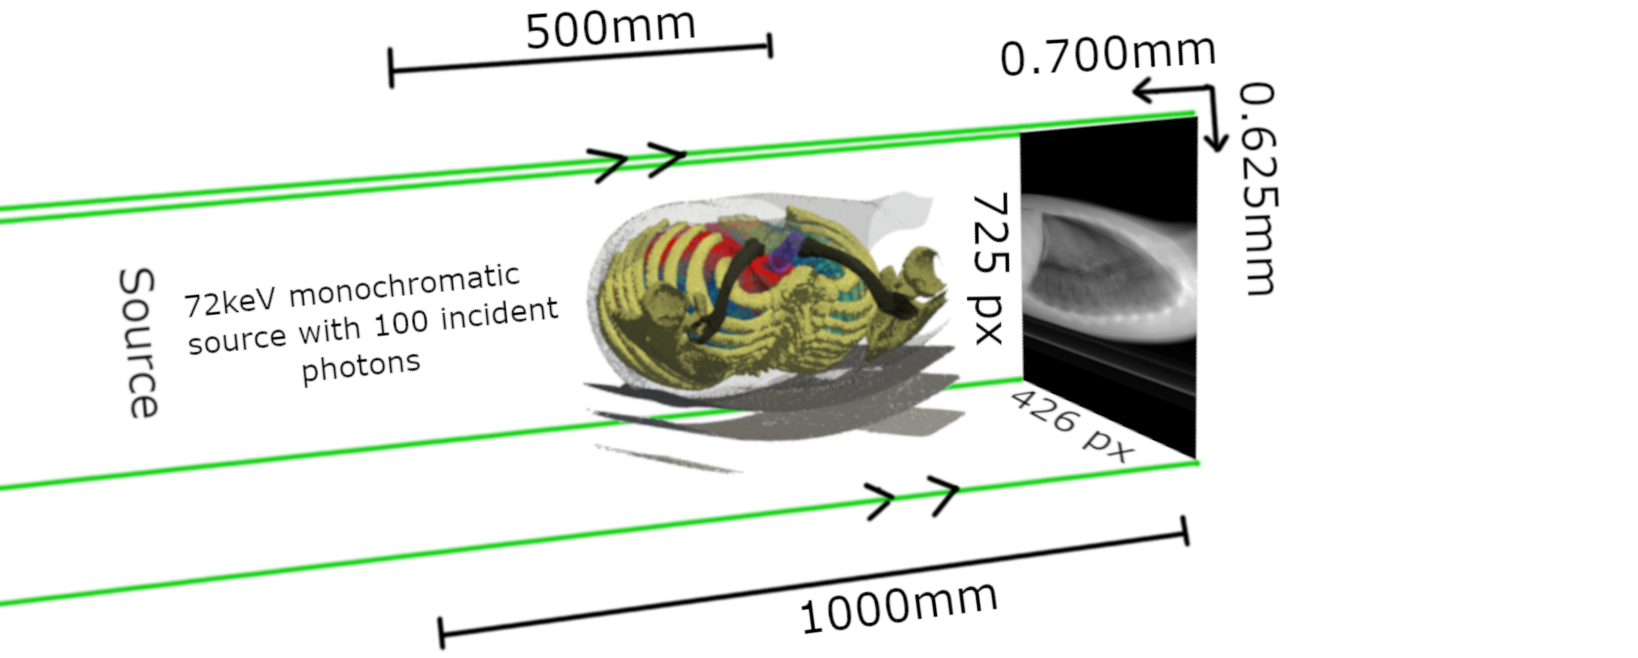

In [65]:
from IPython.display import display
from IPython.display import Image

Image("../doc/gvxr-lungman-environment.png", width=800)

# Results

From qauntative measures we achieved: a ZNCC score of 0.977 (97.7% similarity), a MAPE/MAPD 0.293 and a SSIM score of 0.896. For reference, a good ZNCC and SSIM score is 1 and a good MAPE score is 0.

In [50]:
import SimpleITK as sitk
import numpy as np
import numpy.ma as ma # Masking
from utils import *
from convertRaw import *
import gvxrPython3 as gvxr
import json2gvxr
import matplotlib.pyplot as plt
from tifffile import imread, imsave # Load/Write TIFF file
from threading import Thread
from skimage.transform import iradon
from sitk2vtk import *
from sklearn.metrics import mean_absolute_percentage_error as mape
from skimage.metrics import structural_similarity as ssim
#import scipy
import os
import zipfile

# Performance
**The number of threads chosen will largely dictate the speed of reconstruction.**


**The number of projections will affect the quality of the reconstruction.**

**Artefact filtering, as you can expect, provides better quality image at the expense of speed.**

**Artefact filtering on the GPU gives a decent compromise of speed to quality.**

In [2]:
NUM_RECON_THREADS = 4;
#NUM_PROJECTIONS = 804;
NUM_PROJECTIONS = 360;

DO_ARTEFACT_FILTERING_ON_CPU = False
DO_ARTEFACT_FILTERING_ON_GPU = False

g_iRayEnergy = 68

# Extract data for this experiment

In [3]:
if (False == os.path.isdir("./lungman_data/segmentation-uncompressed")):
    with zipfile.ZipFile(  "./lungman_data/segmentation-compressed.zip", 'r') as myzip:
        myzip.extractall(  "./lungman_data/segmentation-uncompressed")
    
mapHandle = open("./lungman_data/segmentation-uncompressed\map.dat");
bytes = mapHandle.read();
split_lines = bytes.split('\n');
bytes = None;
mapHandle.close();
rd = vtk.vtkMetaImageReader();

for i in range(0, len(split_lines)):
    
    #isovalue HU labelFileName
    tuple_parts = split_lines[i].split('\t');
    
    # See if the stl file already exists
    stl_rel_path = "./lungman_data/meshes/" + tuple_parts[2][0:-4] + ".stl";
    if (True == os.path.isfile(stl_rel_path)): continue;
    
    label_rel_path = "./lungman_data/segmentation-uncompressed/" + tuple_parts[2];
    print(label_rel_path);
    # read mha image
    rd.SetFileName(label_rel_path);
    rd.Update()
    vtkIm = rd.GetOutput();
    
    # Extract surface and save
    isovalue = int(tuple_parts[0]);
    vtkSurface = extractSurface(vtkIm, isovalue);
    writeSTL(vtkSurface, stl_rel_path);
    vtkSurface = None;
    vtkIm = None;

rd = None;


# Configure gVirtualXRay environment
**Create an OpenGL context and window.**

In [4]:
json2gvxr.initGVXR("notebook-10.json", "OPENGL");

Create an OpenGL context: 512x512


In [5]:
json2gvxr.initSourceGeometry();

Set up the beam
	Source position: [0, -500, 0, 'mm']
	Source shape: ParallelBeam


In [6]:
json2gvxr.initDetector("notebook-10.json");

Set up the detector
	Detector position: [0, 500, 0, 'mm']
	Detector up vector: [0, 0, 1]
	Detector number of pixels: [725, 426]
	Pixel spacing: [0.625, 0.7, 'mm']


In [7]:
gvxr.setMonoChromatic(g_iRayEnergy, "keV", 100);

In [8]:
json2gvxr.initSamples("notebook-10.json", 1);

Load the 3D data

	Load 100HU_tumours in lungman_data/meshes/tumours_100HU.stl using mm
	Load -630HU_tumours in lungman_data/meshes/tumours_630HU.stl using mm
	Load Clavicle in lungman_data/meshes/clavicle.stl using mm
	Load Heart in lungman_data/meshes/heart.stl using mm
	Load Bronchus in lungman_data/meshes/bronchus.stl using mm
	Load Diaphram in lungman_data/meshes/diaphram.stl using mm
	Load Bronchioles in lungman_data/meshes/bronchioles.stl using mm
	Load Ribs_Spine in lungman_data/meshes/ribs_spine.stl using mm
	Load Scapulas in lungman_data/meshes/scapulas.stl using mm
	Load Sheets_high in lungman_data/meshes/sheets_high.stl using mm
	Load Sheets_low in lungman_data/meshes/sheets_low.stl using mm
	Load Sheets_med in lungman_data/meshes/sheets_med.stl using mm
	Load Skin in lungman_data/meshes/skin.stl using mm
	Load Sternum in lungman_data/meshes/sternum.stl using mm
	Load Trachea in lungman_data/meshes/trachea.stl using mm


(-0.5, 511.5, 511.5, -0.5)

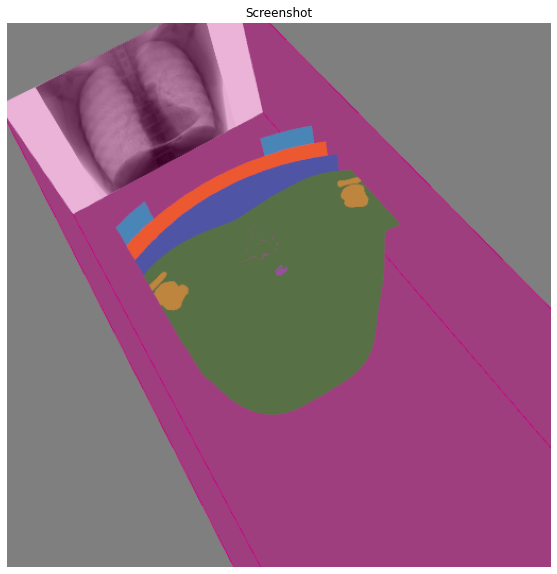

In [9]:

gvxr.computeXRayImage()
gvxr.displayScene()

alpha = 0.2;
for i in range(gvxr.getNumberOfChildren('root')):
    label = gvxr.getChildLabel('root', i);
    pRGBA = gvxr.getAmbientColour(label);
    gvxr.setColour(label, pRGBA[0], pRGBA[1], pRGBA[2],alpha);

gvxr.useLighing(False)
gvxr.useWireframe(False)
gvxr.setZoom(1000)
gvxr.setSceneRotationMatrix([ 0.8535534,  0.5000000, -0.1464466,0,
  -0.5000000,  0.7071068, -0.5000000,0,
  -0.1464466,  0.5000000,  0.8535534,0,
                            0.0, 0.0, 0.0, 1.0])
gvxr.displayScene()


screenshot = gvxr.takeScreenshot()

plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')


# Do projections

In [10]:

if      (DO_ARTEFACT_FILTERING_ON_GPU): gvxr.enableArtefactFilteringOnGPU();
elif    (DO_ARTEFACT_FILTERING_ON_CPU): gvxr.enableArtefactFilteringOnCPU();
    
angular_step = 180 / NUM_PROJECTIONS;
angle = 0;
g_theta = [];
projection_set =[];
for i in range(0, NUM_PROJECTIONS):
    gvxr.resetSceneTransformation();
    gvxr.rotateScene(angle, 0, 0, 1);
    g_theta.append(angle);
    xray_image = np.array(gvxr.computeXRayImage());
    projection_set.append(xray_image);
    angle += angular_step;

#projection_set = gvxr.computeProjectionSet(0, 0, 0, "mm", NUM_PROJECTIONS, angular_step);

projection_set = np.array(projection_set);
projection_set = projection_set / gvxr.getUnitOfEnergy("keV");

gvxr.destroyAllWindows();

# Correct flat-field

In [11]:
# Create a mock dark field image
dark_field_image = np.zeros(projection_set.shape);

# Create a mock flat field image
flat_field_image = np.ones(projection_set.shape);

# Retrieve the total energy
total_energy = 0.0;
energy_bins = gvxr.getEnergyBins("keV");
photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

for energy, count in zip(energy_bins, photon_count_per_bin):
    total_energy += energy * count;
flat_field_image *= total_energy;
    
# Apply the actual flat-field correction on the raw projections
projection_set = (projection_set - dark_field_image) / (flat_field_image - dark_field_image)

dark_field_image = None
flat_field_image = None

# Negative log normalisation

In [12]:
# Make sure no value is negative or null (because of the log function)
# It should not be the case, however, when the Laplacian is used to simulate
# phase contrast, negative values can be generated.
threshold = 0.000000001
projection_set[projection_set < threshold] = threshold;

# Apply the minus log normalisation
projection_set = -np.log(projection_set);

# Rescale the data taking into account the pixel size
pixel_spacing_in_mm = gvxr.getDetectorSize("mm")[0] / gvxr.getDetectorNumberOfPixels()[0]
projection_set /= pixel_spacing_in_mm * (gvxr.getUnitOfLength("mm") / gvxr.getUnitOfLength("cm"));

# Make sure the data is in single-precision floating-point numbers
projection_set = np.array(projection_set).astype(np.single)

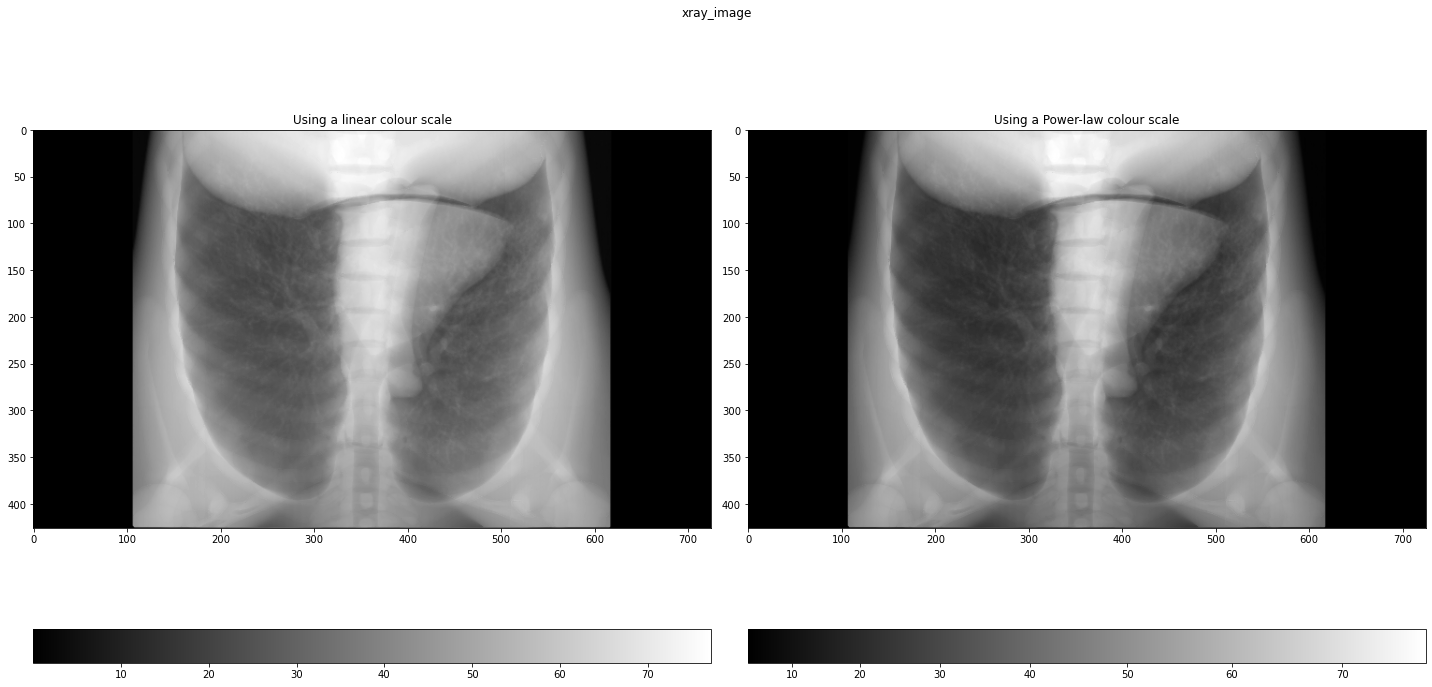

In [13]:
displayLinearPowerScales(projection_set[0], "xray_image", "plots/xray_image");

# Reconstruct CT

In [14]:
def recon(sinograms, CT_to_append_to, theta, iStart, iEnd):
    for i in range(iStart, iEnd):
        data = np.copy(sinograms[i].T);
        slice = iradon(data, theta=theta, circle=False);
        CT_to_append_to[i] = slice;
        format = "reconstructed slice {iSlice}";
        print(format.format(iSlice =i));

In [15]:

#Match an angle to each projection for iradon param
theta = [];
for i in range(NUM_PROJECTIONS): theta.append(i * angular_step);

#Slice to obtain set of sinograms
projection_set = np.swapaxes(projection_set, 0, 1);

num_projections = len(projection_set);
Simulated_CT_in_MU = [None] * num_projections;
handle_recon_threads = [];
iThreadIdx = 0;
num_slices_per_thread = (int)(num_projections / NUM_RECON_THREADS)

for i in range(0, num_projections):
    
    if i % num_slices_per_thread == 0 and iThreadIdx < NUM_RECON_THREADS:
        
        if (iThreadIdx == NUM_RECON_THREADS - 1): #do remainder too
            iEnd = len(projection_set); 
        else:
            iEnd = i + num_slices_per_thread;
            
        handle_recon_threads.append(Thread(target=recon, 
                                           args=(projection_set, 
                                                 Simulated_CT_in_MU, 
                                                 theta, 
                                                 i, iEnd)));
        handle_recon_threads[iThreadIdx].start()
        iThreadIdx+=1;
        format = "Starting thread {iThreadNum}";
        print(format.format(iThreadNum =iThreadIdx));
   

for i in range(len(handle_recon_threads)):
    handle_recon_threads[i].join()
    


Starting thread 1
Starting thread 2
Starting thread 3
Starting thread 4
reconstructed slice 0
reconstructed slice 106
reconstructed slice 318
reconstructed slice 212
reconstructed slice 107
reconstructed slice 319
reconstructed slice 213
reconstructed slice 1
reconstructed slice 108
reconstructed slice 320reconstructed slice 214

reconstructed slice 2
reconstructed slice 321
reconstructed slice 109
reconstructed slice 215
reconstructed slice 3
reconstructed slice 322
reconstructed slice 110
reconstructed slice 216
reconstructed slice 4
reconstructed slice 323
reconstructed slice 111
reconstructed slice 217
reconstructed slice 5
reconstructed slice 324
reconstructed slice 112
reconstructed slice 218
reconstructed slice 6
reconstructed slice 325
reconstructed slice 113
reconstructed slice 219
reconstructed slice 7
reconstructed slice 326
reconstructed slice 114
reconstructed slice 220
reconstructed slice 8
reconstructed slice 327
reconstructed slice 115
reconstructed slice 9
reconstructe

reconstructed slice 297
reconstructed slice 192
reconstructed slice 404
reconstructed slice 86
reconstructed slice 298
reconstructed slice 193
reconstructed slice 405
reconstructed slice 87
reconstructed slice 299
reconstructed slice 406
reconstructed slice 194
reconstructed slice 88
reconstructed slice 300
reconstructed slice 407
reconstructed slice 195
reconstructed slice 89
reconstructed slice 301
reconstructed slice 408
reconstructed slice 196
reconstructed slice 90
reconstructed slice 302
reconstructed slice 409
reconstructed slice 197
reconstructed slice 91
reconstructed slice 303
reconstructed slice 410
reconstructed slice 198
reconstructed slice 92
reconstructed slice 304
reconstructed slice 411
reconstructed slice 199
reconstructed slice 93
reconstructed slice 305
reconstructed slice 412
reconstructed slice 200
reconstructed slice 94
reconstructed slice 306
reconstructed slice 413
reconstructed slice 201
reconstructed slice 95
reconstructed slice 307
reconstructed slice 414
re

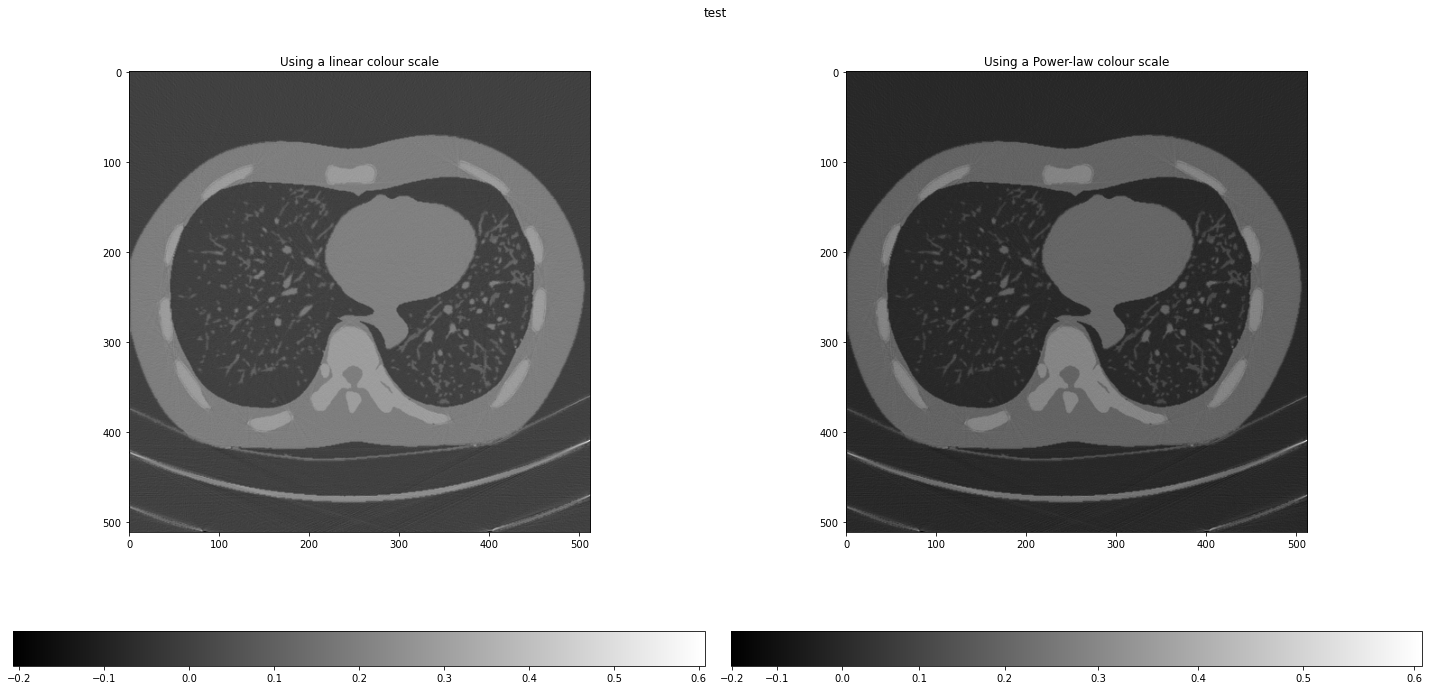

In [16]:
displayLinearPowerScales(Simulated_CT_in_MU[150], "test", "plots/test");
    

# Transform to Hounsfield units

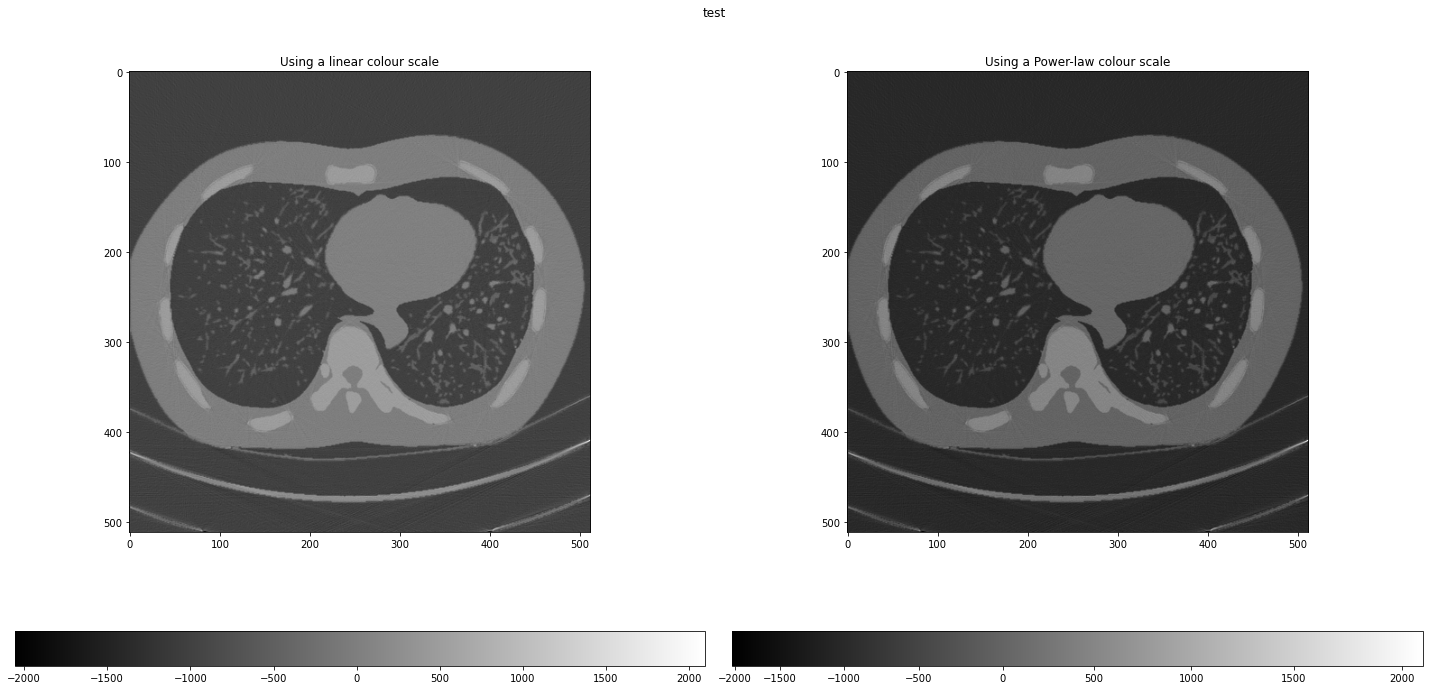

In [17]:
MU_air = gvxr.getMuFromHU(-1000.0, g_iRayEnergy, "keV");
MU_water = gvxr.getMuFromHU(0, g_iRayEnergy, "keV");

Simulated_CT_in_MU = np.array(Simulated_CT_in_MU);

Simulated_CT_in_HU = 1000.0 * ((Simulated_CT_in_MU - MU_water) / (MU_water - MU_air));
displayLinearPowerScales(Simulated_CT_in_HU[150], "test", "plots/test");

Simulated_CT_in_MU = None;

In [18]:
sitk_reader = sitk.ImageFileReader();
sitk_reader.SetImageIO("MetaImageIO");
sitk_reader.SetFileName("lungman_data/lungman.mha");
Ground_truth_CT = np.array(sitk.GetArrayFromImage(sitk_reader.Execute()));

Ground_truth_CT = Ground_truth_CT.astype(np.single);
Simulated_CT_in_HU = Simulated_CT_in_HU.astype(np.single);



# Visual comparisons

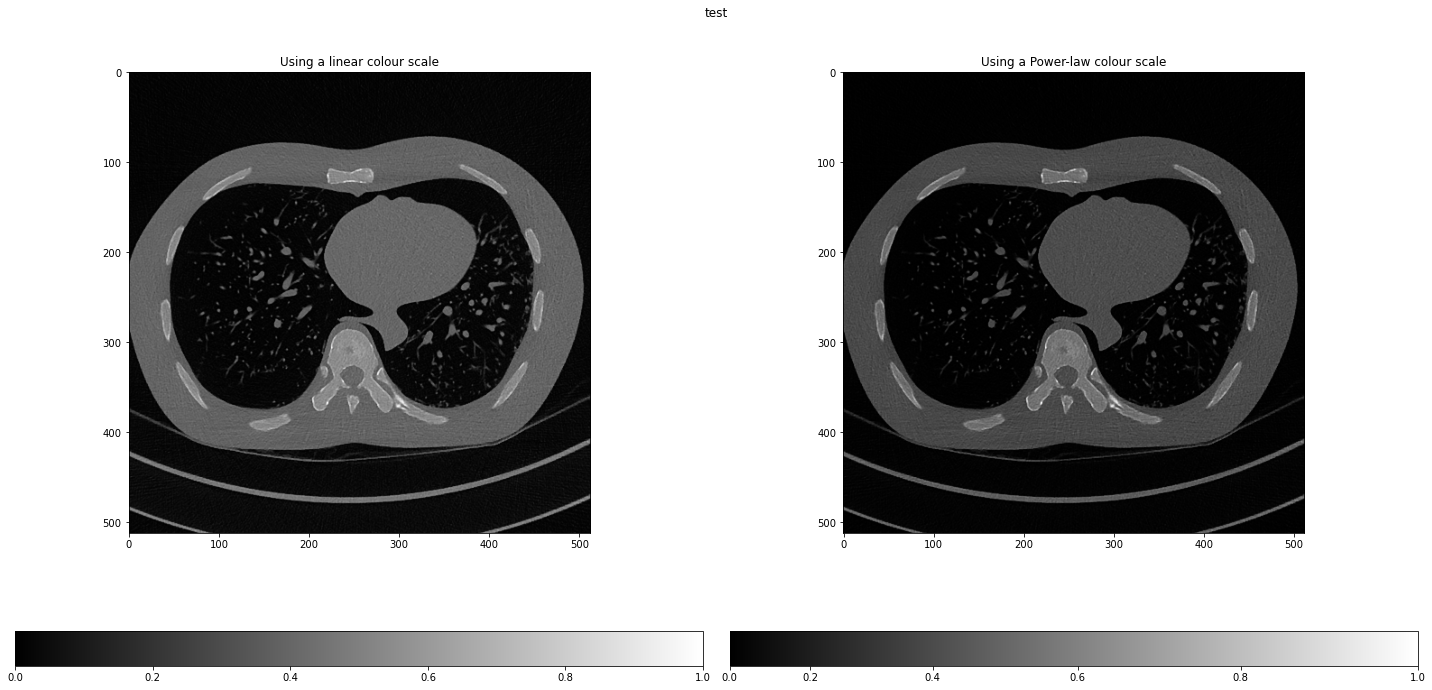

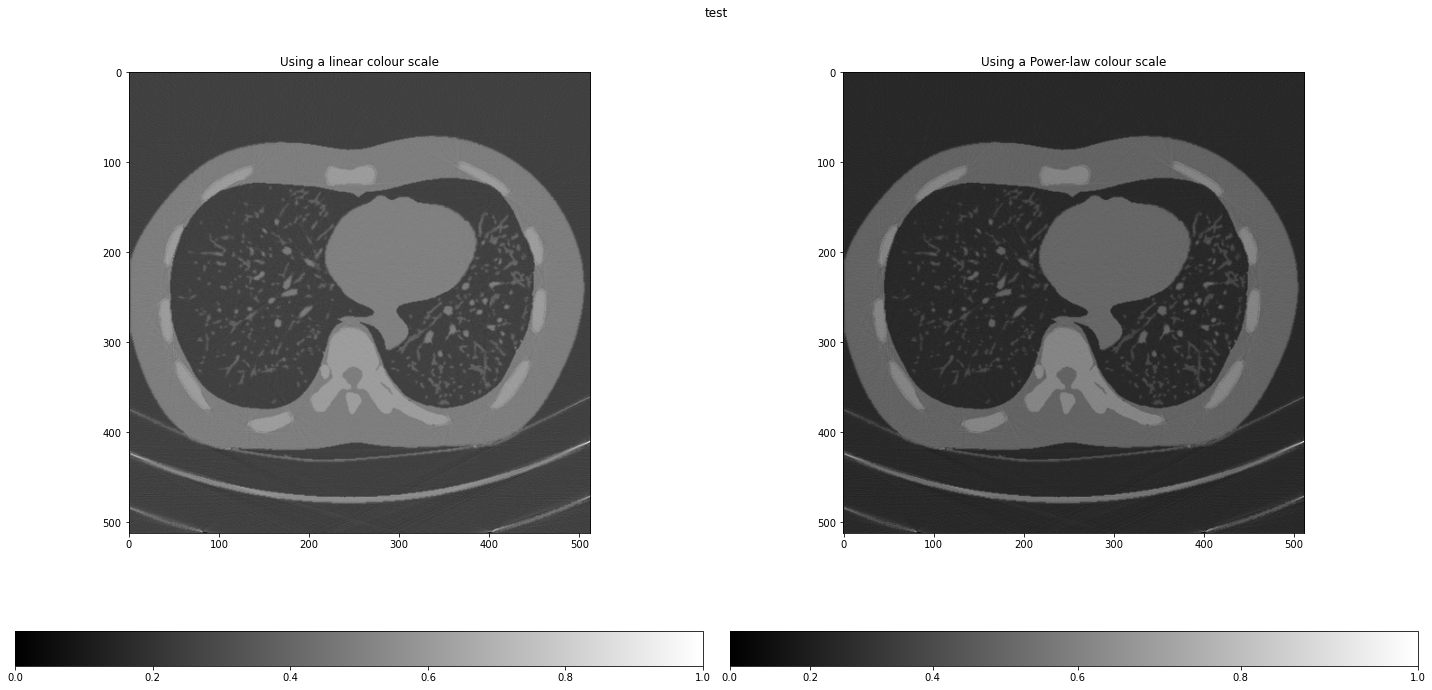

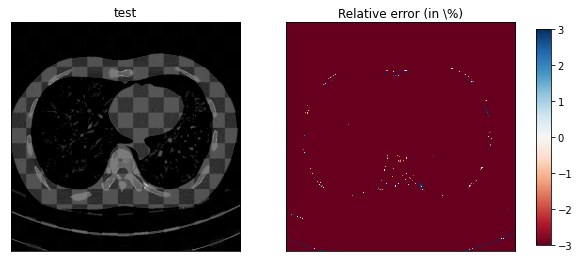

In [19]:
im2 = Simulated_CT_in_HU[150].astype(np.single);
im1 = Ground_truth_CT[150].astype(np.single);
std1 = np.std(im1);
std2 = np.std(im2);
#im1 = (im1 - np.mean(im1)) / (std1);
#im2 = (im2 - np.mean(im2)) / (std2);
im1 = (im1 - np.min(im1)) / (np.max(im1) - np.min(im1));
im2 = (im2 - np.min(im2)) / (np.max(im2) - np.min(im2));
im1[im1 == 0] = 0.00001;
im2[im2 == 0] = 0.00001;

compareImages(im1, im2, "test","plots/test");

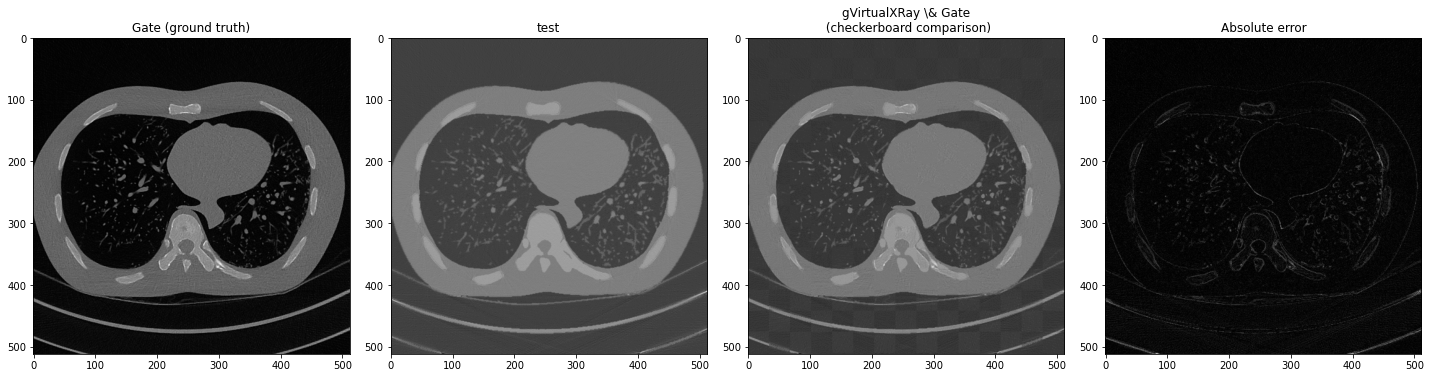

In [20]:
fullCompareImages(Ground_truth_CT[150], Simulated_CT_in_HU[150], "test","plots/test");

# Quantifiable comparisons

In [21]:
#Remember put in util.py
def calculateZNCC(ground, predict):
    
    dims = np.shape(ground);
    #print(dims);
    denom = 1;
    for i in range(len(dims)):
        denom *= dims[i];
    if (denom == 0): return 0;

    ground_mean = np.mean(ground);
    predict_mean = np.mean(predict);

    ground_std  = np.std(ground);
    predict_std = np.std(predict);

    sum = np.sum(
             (float(1) / (ground_std * predict_std)) 
            *(ground  - ground_mean)
            *(predict - predict_mean)
            );
        
    zncc_score = sum / denom;
    return zncc_score

In [22]:
zncc_score = calculateZNCC(Ground_truth_CT, Simulated_CT_in_HU)
format = "ZNCC score: {score:.3f}%";
print (format.format(score=zncc_score));

ZNCC score: 0.974%


In [23]:
def calculateMAPE(ground, predict):
    
    num_voxels = 1;
    dims = np.shape(ground);
    for i in range(len(dims)):
        num_voxels *= dims[i];
    
    ground_flat = ground.ravel();#ground.flat;#ground.flatten();
    predict_flat =predict.ravel();#predict.flat;# predict.flatten();
    
    acc = 0;
    for i in range(0,num_voxels):
        ground_val = ground_flat[i];
        if (ground_val == 0): 
            ground_val = 1;
        #if (ground_val != 0):
        acc += (ground_val - predict_flat[i]) / ground_val;
        
    return acc / num_voxels;

In [24]:
mape_score = calculateMAPE(Ground_truth_CT, Simulated_CT_in_HU);
format = "MAPE score: {score:.3f}%";
print (format.format(score=mape_score));
print(mape(Ground_truth_CT[50], Simulated_CT_in_HU[50]));

MAPE score: 0.293%
562626000000000.0


In [25]:

num_slices = np.shape(Ground_truth_CT)[0];

ground_max = Ground_truth_CT.max();
simulated_max = Simulated_CT_in_HU.max();
ground_min = Ground_truth_CT.min();
simulated_min = Simulated_CT_in_HU.min();

#max = ground_max > simulated_max ? ground_max : simulated_max;
range = max(ground_max , simulated_max) - min(ground_min, simulated_min);
acc = 0;
i = 0;
#High mem when doing whole volume so...
while(i < num_slices):
    acc += ssim(Ground_truth_CT[i], Simulated_CT_in_HU[i], data_range=range);
    i+=1;

ssim_score = acc / num_slices;

format = "SSIM score: {score:.3f}%";
print (format.format(score=ssim_score));

SSIM score: 0.896%


In [59]:
sitk_meta_reader = sitk.ImageFileReader();
sitk_meta_reader.SetImageIO("MetaImageIO");

mapHandle = open("./lungman_data/segmentation-uncompressed/map.dat");
bytes = mapHandle.read();
split_lines = bytes.split('\n');
bytes = None;
mapHandle.close();

acc_avg_rel_diff = 0;
vec_avg_rel_diff = [];
i = 0;
while ( i < len(split_lines)):
    #isovalue HU labelFileName
    tuple_parts = split_lines[i].split('\t');
    label_rel_path = "./lungman_data/segmentation-uncompressed/" + tuple_parts[2];
    
    sitk_meta_reader.SetFileName(label_rel_path);
    sitk_mask = sitk_meta_reader.Execute();
   
    erode = sitk.BinaryErodeImageFilter();
    erode.SetKernelRadius(3);
    erode.SetForegroundValue(int(tuple_parts[0]));
    sitk_mask = erode.Execute(sitk_mask);
    mask = np.array(sitk.GetArrayFromImage(sitk_mask));
    sitk_mask = None
    mask[mask > 0] = 1;
    #mask = ndimage.binary_erosion(mask).astype(mask.dtype)
    
    simulated_masked = ma.masked_array(Simulated_CT_in_HU, mask=mask);
    avg_simulated_HU = float(np.mean(simulated_masked));
    avg_ground_HU = float(tuple_parts[1]);
    avg_rel_diff = (avg_ground_HU - avg_simulated_HU) / avg_ground_HU;
    abs_diff =  avg_simulated_HU - avg_ground_HU;
    print(avg_simulated_HU);
    print(avg_ground_HU);
    format = "Relative difference for {structure} = {rel}, Absolute difference = {abs}";
    print(format.format(structure=tuple_parts[2], rel=avg_rel_diff, abs=abs_diff));
    
    acc_avg_rel_diff += avg_rel_diff;
    vec_avg_rel_diff.append(acc_avg_rel_diff);
    i+=1;
    
avg_rel_diff = acc_avg_rel_diff / len(vec_avg_rel_diff);
print(avg_rel_diff);

-579.5909624413146
-463.668
Relative difference for bronchioles.mha = -0.25001285929008377, Absolute difference = -115.92296244131455
-579.6640279656253
-25.8574
Relative difference for bronchus.mha = -21.417722894244022, Absolute difference = -553.8066279656254
-579.3391405738448
-915.547
Relative difference for trachea.mha = 0.3672207537419217, Absolute difference = 336.2078594261552
-598.8208950462023
-13.2063
Relative difference for diaphram.mha = -44.34357806851292, Absolute difference = -585.6145950462022
-726.6101830741837
-11.6906
Relative difference for skin.mha = -61.15336963664686, Absolute difference = -714.9195830741837
-592.0435135752942
28.3208
Relative difference for heart.mha = 21.904900764642743, Absolute difference = -620.3643135752942
-591.5018522466243
450.319
Relative difference for ribs_spine.mha = 2.313517422641781, Absolute difference = -1041.8208522466243
-584.398579770749
417.469
Relative difference for scapulas.mha = 2.3998610190714738, Absolute difference =